In [1]:
import os.path

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import numpy as np

from scipy import stats
from scipy.spatial.distance import cosine

% matplotlib inline
import matplotlib.pyplot as plt

from collections import OrderedDict

import torchvision
from torchvision import transforms

from mnist_cnn import *
from utils import *

from functools import partial
set_ticks = partial(set_ticks, rotation='horizontal')

In [2]:
DISABLE_CUDA = False

if not DISABLE_CUDA and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
dataset = MNIST(
    os.path.join(*'data/MNIST'.split('/')),
    batch_size=32, val_size=.2
)

In [4]:
model = load_model(mnist_model(), os.path.join('models', 'mnist.pt'), device)

model.eval()
test_accuracy = 0

with torch.no_grad():
    for X, y, label in dataset.test_loader:
        X = X.to(device); y = y.to(device)

        pred = model(X)
        test_accuracy += (torch.argmax(pred, 1) == y).sum()

test_accuracy = test_accuracy.item() / dataset.test_size

print('Test accuracy: %.3f' % test_accuracy)
print('Test error rate: %.3f' % (1 - test_accuracy))

Test accuracy: 0.993
Test error rate: 0.007


In [5]:
emb_dim = 100

vae = ConvVAE(emb_dim).to(device)
model_path = os.path.join('models', 'conv_vae_mnist.pt')
vae.load_state_dict(torch.load(model_path))

vae = vae.eval()

In [6]:
import json

with open(os.path.join('data', 'mnist_conv_vae_norm_means.json')) as f:
    vae.norm_means = json.load(f)
    
vae.norm_means = { int(k): v for k, v in vae.norm_means.items() }

vae.norm_means

{-1: 3.035032272338867,
 0: 3.311706066131592,
 1: 2.793889045715332,
 2: 3.243734359741211,
 3: 2.9805784225463867,
 4: 3.1270899772644043,
 5: 3.0062901973724365,
 6: 3.2144525051116943,
 7: 3.094365119934082,
 8: 2.849363327026367,
 9: 2.7558236122131348}

19398
3.17325179821637e-06


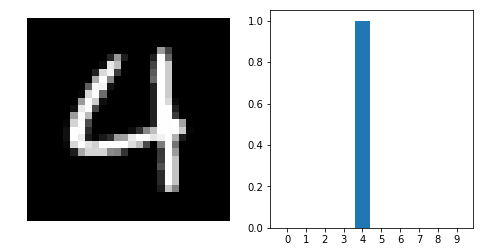

In [11]:
idx = 19398 # (4 to 9)
print(idx)
train_idx = dataset.train[idx]
original_img, real_label, real_class = dataset[train_idx]

axes = subplots(1, 2)

imshow(original_img[0], axes[0])

pred = model(original_img.unsqueeze(0).cuda())
    
ps = F.softmax(pred, dim=1)[0]
entropy = -(ps * torch.log2(ps)).sum()

print(entropy.item())
axes[1].bar(np.arange(dataset.num_classes), ps.detach())
set_ticks(dataset, axes[1])

Idx 19398 (4): from 4 to 9


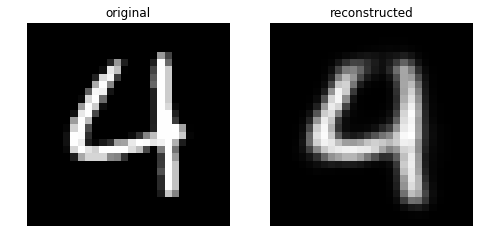

In [12]:
# Move img to device
original_img = original_img.to(device)
real_label = torch.tensor(int(real_label)).to(device)

# Obtain image encoding
unsqueezed = original_img.unsqueeze(0)
mu, logvar = vae.encode(unsqueezed)
original_emb = vae.find_closest_embedding(device, unsqueezed, mu, logvar, n_samples=100)[0]
reconstructed_img = vae.decode(original_emb.unsqueeze(0))[0].detach()

axes = subplots(1, 2)

for ax, img, title in zip(
    axes, [original_img, reconstructed_img], 
    ['original', 'reconstructed']
):
    imshow(img[0].detach(), ax, title=title)
    
new_label = torch.sort(pred[0])[1]

if new_label[-1] == real_label:
    original_label = real_label
    new_label = new_label[-2]
else: # wrongly predicted
    original_label = new_label[-1]
    new_label = real_label
    
print('Idx %d (%s): from %s to %s' % (idx, real_class, dataset.classes[original_label], dataset.classes[new_label]))

In [13]:
def semantic_morphing(
    model, vae, device, original_emb, new_label,
    optimizer=optim.Adam, lr=1e-3, 
    entropy_threshold=.01, max_epochs=1000, alpha_lk=1.
):
    original_emb = original_emb.clone()
    emb = nn.Parameter(original_emb.unsqueeze(0).to(device))
    obj_norm = vae.norm_means[int(new_label)]
    
    optimizer = optimizer([emb], lr=lr)
    
    pred_loss_avg = 0
    lk_loss_avg = 0
    
    losses = []
    
    for epoch in range(1, max_epochs + 1):
        optimizer.zero_grad()
        model.zero_grad()
        vae.zero_grad()

        decoded = vae.decode(emb)
        pred = model(decoded)

        ps = F.softmax(pred, dim=1)[0]
        entropy = -(ps * torch.log2(ps)).sum()

        if entropy.item() < entropy_threshold and pred[0].argmax() == new_label:
            break
        
        pred_loss = -pred[0, new_label] # maximize
        lk_loss = (emb.norm(p=2) - obj_norm) ** 2
        
        # Compute loss means
        pred_loss_avg = (pred_loss_avg * (epoch - 1) + pred_loss.abs().detach()) / epoch
        lk_loss_avg = (lk_loss_avg * (epoch - 1) + lk_loss.abs().detach()) / epoch
        
        # Define loss and optimize
        loss = (
            pred_loss + 
            alpha_lk * lk_loss * pred_loss_avg / lk_loss_avg
        )
        
        loss.backward(retain_graph=True)
        optimizer.step()
        
        losses.append((pred_loss, lk_loss, loss))
        
    emb = emb[0].detach()
    decoded = vae.decode(emb.unsqueeze(0))[0].detach()
    
    if losses:
        losses = [
            torch.Tensor([row[i] for row in losses])
            for i in range(len(losses[0]))
        ]
    
    return emb, decoded, losses

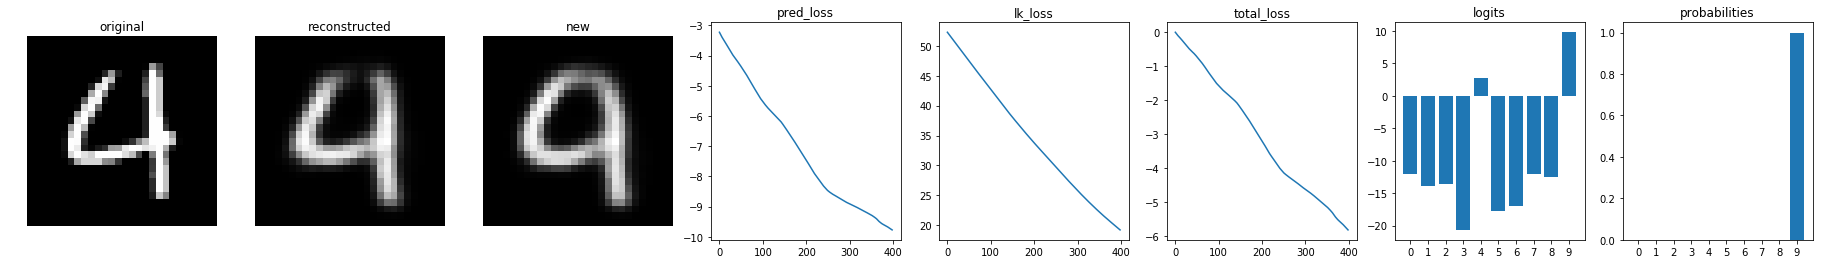

In [14]:
new_emb, new_img, losses = semantic_morphing(
    model, vae, device, original_emb, new_label,
    lr=1e-3, entropy_threshold=.01, max_epochs=1000, alpha_lk=1.
)

axes = subplots(1, 3 + len(losses) + 2)
losses_titles = [
    'pred_loss', 'lk_loss', 'total_loss'
]

for ax, img, title in zip(
    axes[:3], [original_img, reconstructed_img, new_img], 
    ['original', 'reconstructed', 'new']
):
    imshow(img[0].detach(), ax, title=title)
    
for i, (ax, title) in enumerate(zip(axes[3:-2], losses_titles)):
    ax.plot(losses[i].cpu().detach().numpy())
    ax.set_title(title)

pred = model(new_img.unsqueeze(0))
pred_ps = F.softmax(pred, dim=1)

for ax, data, title in zip(axes[-2:], [pred, pred_ps], ['logits', 'probabilities']):
    ax.bar(np.arange(10), data[0].cpu().detach().numpy())
    ax.set_title(title)
    set_ticks(dataset, ax)

# Experiments

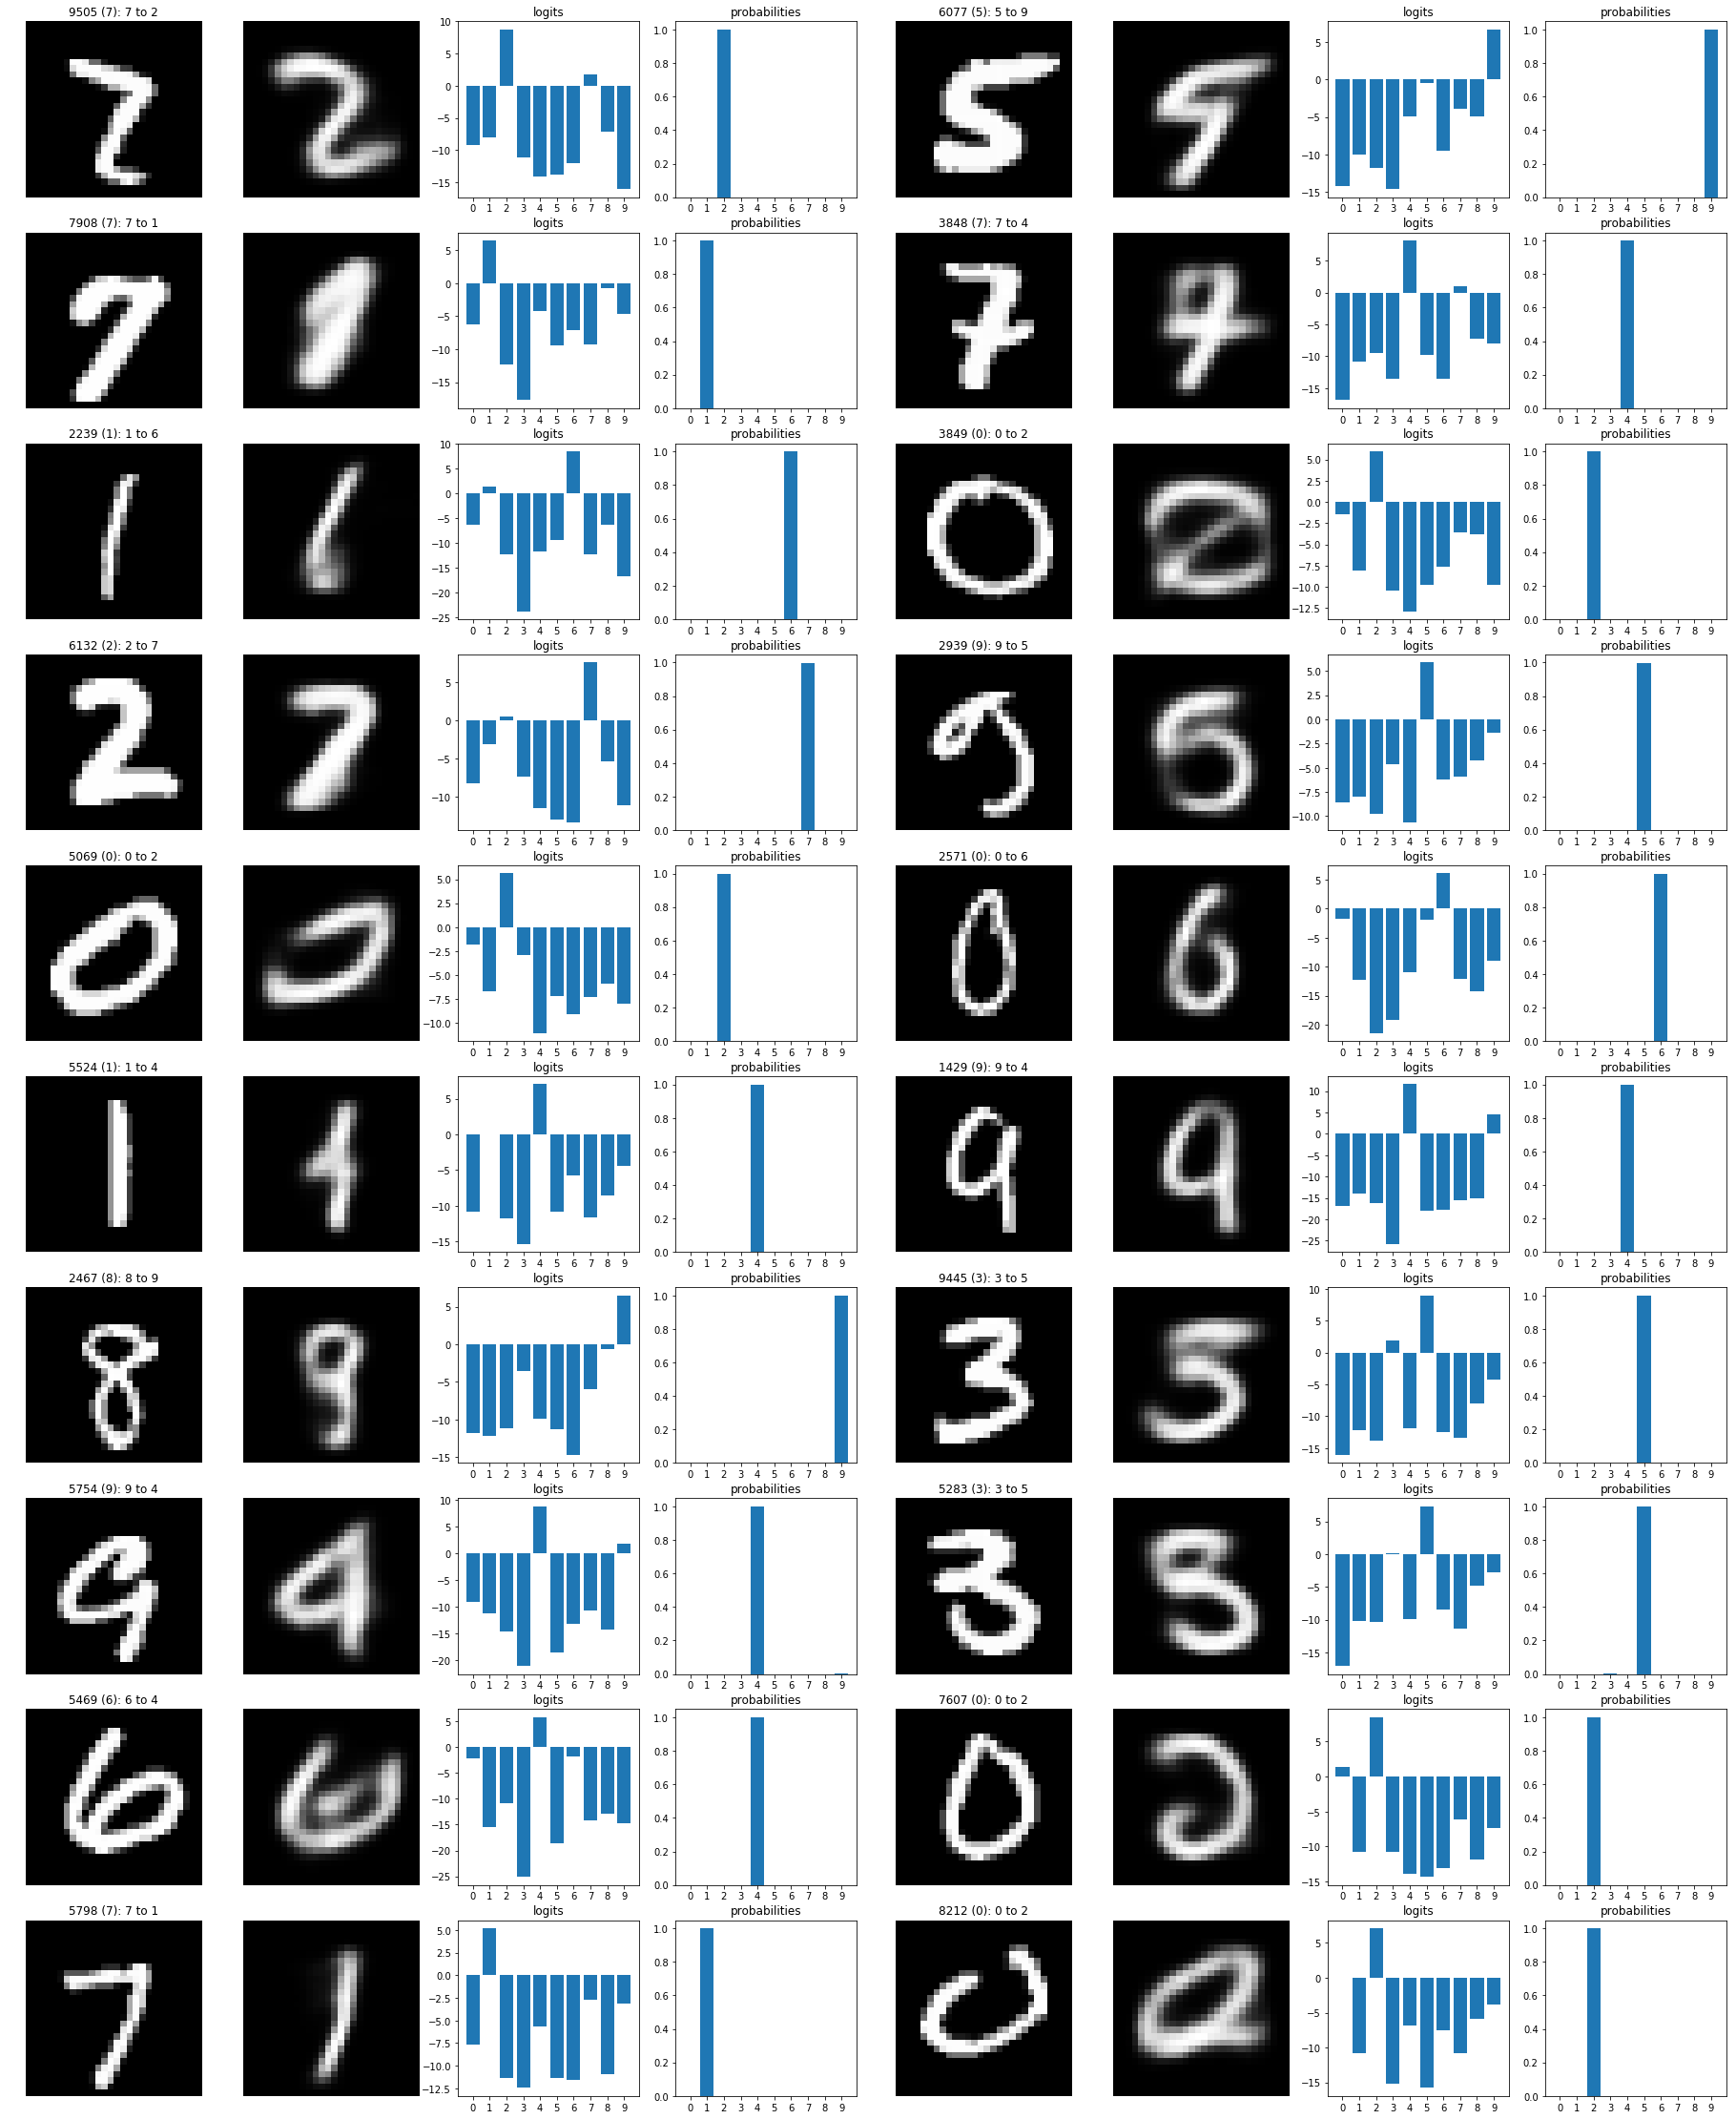

In [15]:
n_samples = 20
max_samples_per_row = 2

N_EPOCHS = 5000
alpha_lk = .1

axes = subplots(
    (n_samples * 4 - 1) // (max_samples_per_row * 4) + 1, 
    max_samples_per_row * 4
)

for ax in axes.flatten()[n_samples * 4:]: ax.axis('off')
axes = axes.flatten()[:n_samples * 4].reshape((n_samples, 4))

for ax_original, ax_new, ax_logits, ax_probs in axes:
    # Define image to optimize
    idx = np.random.choice(dataset.test_size)
    
    test_idx = dataset.test[idx]
    original_img, real_label, real_class = dataset[test_idx]
    original_img = original_img.to(device)
    real_label = torch.tensor(int(real_label)).to(device)
    
    # Obtain image encoding
    unsqueezed = original_img.unsqueeze(0)
    mu, logvar = vae.encode(unsqueezed)
    original_emb = vae.find_closest_embedding(device, unsqueezed, mu, logvar, n_samples=100)[0]
    reconstructed_img = vae.decode(original_emb.unsqueeze(0))[0].detach()
    
    # Obtain "other" label
    pred = model(original_img.unsqueeze(0).to(device))

    ps = F.softmax(pred, dim=1)[0]
    entropy = -(ps * torch.log2(ps)).sum()
    
    new_label = torch.sort(pred[0])[1]

    if new_label[-1] == real_label:
        original_label = real_label
        new_label = new_label[-2]
    else: # wrongly predicted
        original_label = new_label[-1]
        new_label = real_label
        
    new_emb, new_img, losses = semantic_morphing(
        model, vae, device, original_emb, new_label,
        lr=1e-3, entropy_threshold=.01, max_epochs=N_EPOCHS, alpha_lk=alpha_lk
    )

    imshow(original_img[0].detach(), ax_original)
    ax_original.set_title('%d (%s): %s to %s' % (idx, real_class, dataset.classes[original_label], dataset.classes[new_label]))
    
    imshow(new_img[0].detach(), ax_new)

    pred = model(new_img.unsqueeze(0))
    pred_ps = F.softmax(pred, dim=1)

    for ax, data, title in zip(
        [ax_logits, ax_probs], [pred, pred_ps], 
        ['logits', 'probabilities']
    ):
        ax.bar(np.arange(10), data[0].cpu().detach().numpy())
        ax.set_title(title)
        set_ticks(dataset, ax)

In [23]:
# Error rate of the model
n_samples = 100

rs = np.random.RandomState(123)
samples = rs.choice(dataset.test, n_samples, replace=False)

results = []

N_EPOCHS = 5000
alpha_lk = .1

epochs = []

for i, idx in enumerate(samples, 1):
    original_img, real_label, real_class = dataset[idx]
    original_img = original_img.to(device)
    real_label = torch.tensor(int(real_label)).to(device)
    
    # Obtain image encoding
    unsqueezed = original_img.unsqueeze(0)
    mu, logvar = vae.encode(unsqueezed)
    original_emb = vae.find_closest_embedding(device, unsqueezed, mu, logvar, n_samples=100)[0]
    reconstructed_img = vae.decode(original_emb.unsqueeze(0))[0].detach()
    
    # Obtain "other" label
    pred = model(original_img.unsqueeze(0).to(device))

    ps = F.softmax(pred, dim=1)[0]
    entropy = -(ps * torch.log2(ps)).sum()
    
    new_label = torch.sort(pred[0])[1]

    if new_label[-1] == real_label:
        original_label = real_label
        new_label = new_label[-2]
    else: # wrongly predicted
        original_label = new_label[-1]
        new_label = real_label
        
    new_emb, new_img, losses = semantic_morphing(
        model, vae, device, original_emb, new_label,
        lr=1e-3, entropy_threshold=.01, max_epochs=N_EPOCHS, alpha_lk=alpha_lk
    )

    epochs.append(len(losses[0]))
    
    pred = model(new_img.unsqueeze(0))
    pred_ps = F.softmax(pred, dim=1)
    
    results.append(pred_ps[0].argmax() != new_label)
    
    if not i % 100:
        print('#experiments = %.3d, error_rate=%.3f' % (i, torch.Tensor(results).mean()))

#experiments = 100, error_rate=0.030


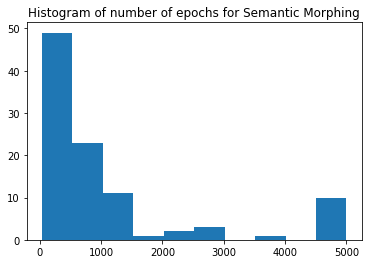

In [26]:
plt.hist(epochs)
plt.title('Histogram of number of epochs for Semantic Morphing');

# Path between original and new

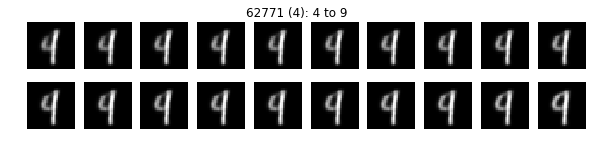

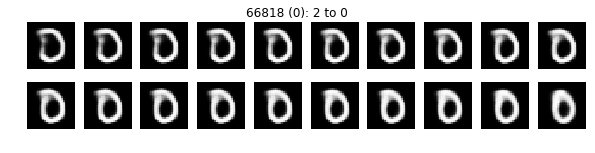

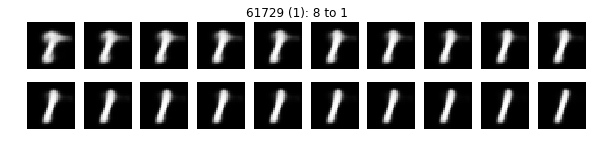

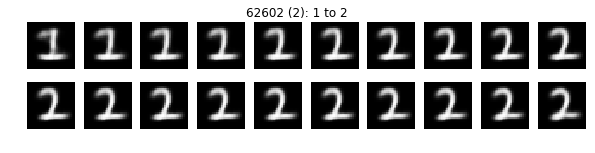

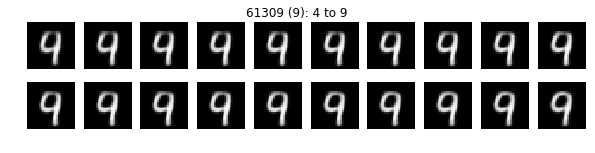

In [30]:
n_samples = 5

for _ in range(n_samples):
    PATH_LENGTH = 20

    idx = np.random.choice(dataset.test)

    # Define image to optimize
    original_img, real_label, real_class = dataset[idx]
    original_img = original_img.to(device)
    real_label = torch.tensor(int(real_label)).to(device)

    # Obtain image encoding
    unsqueezed = original_img.unsqueeze(0)
    mu, logvar = vae.encode(unsqueezed)
    original_emb = vae.find_closest_embedding(device, unsqueezed, mu, logvar, n_samples=100)[0]
    reconstructed_img = vae.decode(original_emb.unsqueeze(0))[0].detach()

    # Obtain "other" label
    original_pred = model(original_img.unsqueeze(0).to(device))

    ps = F.softmax(original_pred, dim=1)[0]
    entropy = -(ps * torch.log2(ps)).sum()

    new_label = torch.sort(original_pred[0])[1]

    if new_label[-1] == real_label:
        original_label = real_label
        new_label = new_label[-2]
    else: # wrongly predicted
        original_label = new_label[-1]
        new_label = real_label

    new_emb, new_img, losses = semantic_morphing(
        model, vae, device, original_emb, new_label,
        lr=1e-3, entropy_threshold=.01, max_epochs=5000, alpha_lk=.1
    )

    path_emb = torch.stack([
        torch.sqrt(1 - alpha) * new_emb + torch.sqrt(alpha) * original_emb
        for alpha in torch.linspace(0, 1, PATH_LENGTH).to(device)
    ], dim=0)

    path = vae.decode(path_emb).detach()

    axes = subplots(2, 10, plot_size=1).flatten()
    axes[0].figure.suptitle(
        '%d (%s): %s to %s' % (idx, real_class, dataset.classes[new_label], dataset.classes[original_label])
    )

    for ax, img in zip(axes, path):
        imshow(img[0], ax)